### **Relevant Data**
- Over the waves, the participants mostly remain the same. According to the codebook, only a few new individuals are added in each wave.
- Based on the EDA, the data must be filtered using the following criteria:
  1. Include only **elderly individuals** (age 50 years or older).
  2. Include only **living individuals** (exclude those who passed away during the waves).
  3. Include only **in-person surveyed participants** (exclude observations based on reports from family members or relatives).
  4. Include only **Respondents** (specific details not visible in this section).

- **Additional Notes**:  
  - Filtering will only consider the last wave (wave 5) because of the significant time gap between waves, which are non-consecutive (approximately three years apart).  
  - **Reason for choosing wave 5**:  
    - Elderly health conditions tend to change annually. Considering this, using wave 5 provides the most recent and reliable data for analyzing meaningful health changes.  


### **Step-by-Step for Exploratory Data Analysis (EDA) and Feature Selection Using Filters**

---

### **1. Understand the Context and Requirements**
1. **Business Objective**: Predict the risk (probability) of hospitalization in older adults.
2. **Data Characteristics**:
   - Panel data: cross-sectional + time series data.
   - Irregular time intervals between waves.
   - Focus on the last wave (wave 5) for prediction due to its relevance and recency.
   - Target variable is highly imbalanced (1.4/8.6).

---

### **2. Exploratory Data Analysis (EDA)**

#### **A. Data Understanding and Delimitation**
1. **Identify the Observation Subjects**:
   - Initial subjects: Respondent (R), Spouse (S), Home (H).
   - Justification: Work only with `Respondent (R)` as their personal characteristics are directly relevant for prediction.
2. **Age Filtering**:
   - Filter older adults: retain only individuals aged 50 years or older.
3. **Available Variables**:
   - Approximately 469 variables after the initial delimitation.

#### **B. Missing Data Analysis**
1. Calculate the percentage of missing values for each column.
2. Visualize missing data:
   - Create a bar plot showing the percentage of missing values by column.
3. **Nature of Missing Data**:
   - Identified as MNAR (Missing Not At Random).
   - Strategy: Treat missing values (`NaN`) as an additional category and let the model determine their relevance.

#### **C. Data Imbalance Analysis**
1. Evaluate the imbalance in the target variable.
2. **Strategy for Imbalanced Data**:
   - Use oversampling techniques like **SMOTE** (Synthetic Minority Oversampling Technique) to balance the dataset.

#### **D. Analysis of Categorical and Numerical Variables**
1. Identify:
   - **Numerical Variables**: Example, hospitalization costs.
   - **Categorical Variables**: Represent 90% of the dataset (binary: 0/1).
2. Identify **cardinality** (unique values):
   - Remove variables with extremely high or low cardinality.

#### **E. Correlation Analysis**
1. Calculate correlation for categorical variables:
   - Use **Cramer’s V** to measure relationships between categorical variables.
2. Calculate correlations for numerical variables:
   - Use Pearson or Spearman correlation.

---

### **3. Feature Selection Using Filters**

#### **A. Filter-Based Feature Selection Methods**
1. **Remove Low Variability**:
   - Eliminate constant or near-constant variables (e.g., columns with variance close to 0).
   - Calculate the variance for each variable and filter based on a low threshold.
2. **Correlation Analysis**:
   - Use correlation to identify redundant variables.
   - Keep only one variable from highly correlated pairs (threshold > 0.8).
3. **Statistical Measures**:
   - Apply techniques such as **Chi-square** (for categorical variables) or **ANOVA** (for numerical variables) to evaluate the relationship between features and the target variable.
4. **Mutual Information**:
   - Calculate mutual information between each variable and the target to measure nonlinear dependencies.
5. **Univariate Selection**:
   - Select the best variables based on univariate statistical tests.

#### **B. Importance-Based Reduction**
1. Use a baseline model like Random Forest to compute feature importance.
2. Select the top 30 variables with the highest importance scores.

---

### **4. Proposed Workflow**

1. **EDA**:
   - Analyze missing data, imbalance, and general characteristics of the dataset.
2. **Initial Filtering**:
   - Filter by age (>50 years), remove low-variance variables, and focus only on Respondents (R).
3. **Preprocessing**:
   - Balance the dataset using SMOTE.
   - Impute or categorize missing values.
4. **Feature Selection**:
   - Apply filter methods (variance, correlation, ANOVA, Chi-square, mutual information).
   - Reduce to the top 30 best features.
5. **Baseline Model**:
   - Train a baseline model with the selected features to evaluate performance.
6. **Fine-Tuning**:
   - Adjust hyperparameters and optimize the final model.



In [101]:
import sys

IN_COLAB = "google.colab" in sys.modules
IN_COLAB

if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

#"content/drive/MyDrive/shared-with-me/anyoneAI_FP"

if IN_COLAB:
    ROOT_DIR = "/content/drive/MyDrive/anyoneAI_FP/"
    %cd $ROOT_DIR


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/anyoneAI_FP


In [102]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import chi2_contingency



def handle_missing_values(df, numeric_placeholder=-999, categorical_placeholder='Missing'):
    """
    Replace missing values in numerical and categorical columns.
    Args:
        df (pd.DataFrame): The input dataset.
        numeric_placeholder: Placeholder for missing numerical values.
        categorical_placeholder: Placeholder for missing categorical values.
    Returns:
        pd.DataFrame: The dataframe with missing values handled.
    """
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            df[col] = df[col].fillna(numeric_placeholder)
        else:  # Categorical columns
            df[col] = df[col].fillna(categorical_placeholder)
    return df


def balance_data(X, y):
    """
    Balance the dataset using SMOTE.
    Args:
        X (pd.DataFrame): Features dataframe.
        y (pd.Series): Target variable.
    Returns:
        tuple: Balanced features (X) and target (y).
    """
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    return X_balanced, y_balanced


def filter_by_age(df, age_column='r5agey', age_threshold=50):
    """
    Filter rows by age threshold.
    Args:
        df (pd.DataFrame): The input dataset.
        age_column (str): The column containing age data.
        age_threshold (int): The minimum age to include.
    Returns:
        pd.DataFrame: Filtered dataset.
    """
    return df[df[age_column] >= age_threshold]



def remove_low_variability(df, threshold=0.01):
    """
    Remove features with low variance after ensuring all columns are numeric.
    Args:
        df (pd.DataFrame): Input dataframe.
        threshold (float): Variance threshold.
    Returns:
        pd.DataFrame: Dataframe with low-variance features removed.
    """
    # Ensure all columns are numeric
    df_numeric = df.select_dtypes(include=['number'])

    # Apply VarianceThreshold
    selector = VarianceThreshold(threshold=threshold)
    df_filtered = selector.fit_transform(df_numeric)

    # Return filtered DataFrame with selected columns
    return pd.DataFrame(df_filtered, columns=df_numeric.columns[selector.get_support()])


def handle_categorical_cardinality(df, max_cardinality=100, min_cardinality=2):
    """
    Remove categorical features with very high or very low cardinality.
    Args:
        df (pd.DataFrame): Input dataframe.
        max_cardinality (int): Maximum allowed unique values.
        min_cardinality (int): Minimum allowed unique values.
    Returns:
        pd.DataFrame: Dataframe with filtered categorical variables.
    """
    for col in df.select_dtypes(include=['object']).columns:
        unique_values = df[col].nunique()
        if unique_values > max_cardinality or unique_values < min_cardinality:
            df = df.drop(columns=[col])
    return df


def calculate_v_cramer(df, categorical_columns):
    """
    Calculate V Cramer correlation for categorical variables.
    Args:
        df (pd.DataFrame): Input dataframe.
        categorical_columns (list): List of categorical column names.
    Returns:
        pd.DataFrame: Correlation matrix for categorical variables.
    """
    def v_cramer(confusion_matrix):
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        return np.sqrt(phi2 / min(k - 1, r - 1))

    corr_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)
    for col1 in categorical_columns:
        for col2 in categorical_columns:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1.0
            else:
                confusion_matrix = pd.crosstab(df[col1], df[col2])
                corr_matrix.loc[col1, col2] = v_cramer(confusion_matrix)
    return corr_matrix


def filter_alive_respondents(df, status_column='r5iwstat', alive_value='1.Resp, alive'):
    """
    Filter the dataset to include only alive respondents based on the R5IWSTAT variable.

    Args:
        df (pd.DataFrame): Input dataset.
        status_column (str): Column name indicating respondent's status (default is 'R5IWSTAT').
        alive_value (int): Value in the status column that represents 'alive' (default is 1).

    Returns:
        pd.DataFrame: Filtered dataset containing only alive respondents.
    """
    # Filter rows where the status column equals the alive value
    filtered_df = df[df[status_column] == alive_value]
    return filtered_df



def analyze_and_handle_missing_values(df, threshold=30):
    """
    Analyze missing values, visualize them, and drop columns exceeding the threshold.

    Args:
        df (pd.DataFrame): Input dataframe.
        threshold (int): Percentage threshold for dropping columns (default: 30).

    Returns:
        pd.DataFrame: Dataframe after dropping columns with excessive missing values.
    """
    # Calculate the percentage of missing values
    missing_percentage = (df.isnull().sum() / len(df)) * 100

    # Visualize missing data
    plt.figure(figsize=(10, 6))
    missing_percentage.sort_values(ascending=False).plot(kind='bar', color='skyblue')
    plt.title("Percentage of Missing Values by Column", fontsize=16)
    plt.xlabel("Columns", fontsize=12)
    plt.ylabel("Percentage of Missing Values", fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

    # Drop columns exceeding the threshold
    columns_to_drop = missing_percentage[missing_percentage > threshold].index
    print(f"Columns dropped (>{threshold}% missing): {list(columns_to_drop)}")

    df = df.drop(columns=columns_to_drop)
    return df


import matplotlib.pyplot as plt

def remove_columns_with_missing_values(df, missing_values_threshold=30, visualize=True):
    """
    Analyze missing values, optionally visualize them, and drop columns exceeding the threshold.

    Args:
        df (pd.DataFrame): Input dataframe.
        missing_values_threshold (int): Percentage threshold for dropping columns (default: 30).
        visualize (bool): Whether to visualize the missing data (default: True).

    Returns:
        pd.DataFrame: Dataframe after dropping columns with excessive missing values.
    """
    # Calculate the percentage of missing values
    missing_percentage = (df.isnull().sum() / len(df)) * 100

    if visualize:
        # Visualize missing data with highlighting for columns exceeding the threshold
        plt.figure(figsize=(10, 6))
        colors = ['red' if val > missing_values_threshold else 'skyblue' for val in missing_percentage]
        missing_percentage.sort_values(ascending=False).plot(kind='bar', color=colors)
        plt.axhline(y=missing_values_threshold, color='gray', linestyle='--', linewidth=1.5, label=f'Threshold ({missing_values_threshold}%)')
        plt.title("Percentage of Missing Values by Column", fontsize=16)
        plt.xlabel("Columns", fontsize=12)
        plt.ylabel("Percentage of Missing Values", fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.show()

    # Identify and drop columns exceeding the threshold
    columns_to_drop = missing_percentage[missing_percentage > missing_values_threshold].index
    print(f"Dropping {len(columns_to_drop)} columns (>{missing_values_threshold}% missing): {list(columns_to_drop)}")

    # Drop the columns
    filtered_df = df.drop(columns=columns_to_drop)

    # Print updated shape
    print(f"Updated dataframe shape: {filtered_df.shape}")

    return filtered_df



def cramers_v(x, y):
    """
    Calculate Cramér's V statistic for categorical association.
    Args:
        x (pd.Series): First categorical variable.
        y (pd.Series): Second categorical variable.
    Returns:
        float: Cramér's V statistic.
    """
    # Ensure inputs are strings
    x, y = x.astype(str), y.astype(str)

    contingency_table = pd.crosstab(x, y)
    if contingency_table.size == 0:  # Handle empty tables
        return np.nan

    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape

    # Handle cases where min(k-1, r-1) is 0
    if min(k - 1, r - 1) == 0:
        return np.nan

    return np.sqrt(phi2 / min(k - 1, r - 1))


def cramers_v_matrix(df):
    """
    Create a Cramér's V correlation matrix for all categorical variables.
    Args:
        df (pd.DataFrame): Dataframe containing categorical variables.
    Returns:
        pd.DataFrame: Cramér's V correlation matrix.
    """
    # Automatically filter categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    # Ensure all categorical columns are strings
    df = df[categorical_columns].astype(str)

    cramers_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

    for col1 in categorical_columns:
        for col2 in categorical_columns:
            if col1 == col2:
                cramers_matrix.loc[col1, col2] = 1.0
            else:
                cramers_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

    return cramers_matrix.astype(float)


def remove_redundant_features_cramers(df, cramers_matrix, threshold=0.8, target_column='r5hosp1y'):
    """
    Use a precomputed Cramér's V matrix to identify and remove redundant categorical features,
    ensuring the target variable is not removed.

    Args:
        df (pd.DataFrame): Dataframe containing categorical variables.
        cramers_matrix (pd.DataFrame): Precomputed Cramér's V correlation matrix.
        threshold (float): Threshold for Cramér's V to consider redundancy.
        target_column (str): The target variable that must not be removed.

    Returns:
        pd.DataFrame: Dataframe with redundant features removed.
    """
    # Identify redundant variables
    redundant_vars = set()
    for col1 in cramers_matrix.columns:
        for col2 in cramers_matrix.columns:
            if col1 != col2 and cramers_matrix.loc[col1, col2] > threshold:
                # Ensure the target variable is not added to redundant features
                if col2 != target_column:
                    redundant_vars.add(col2)

    # Drop redundant variables while preserving the target variable
    reduced_df = df.drop(columns=redundant_vars, errors='ignore')
    print(f"Removed {len(redundant_vars)} redundant features: {redundant_vars}")
    return reduced_df




def handle_all_missing_as_category(df, target_column='r5hosp1y', missing_label='Missing', numerical_fill_value=-1):
    """
    Treat missing values (NaN) in all columns as an additional category for categorical columns
    and assign a default value (-1) for numerical columns, excluding the target column.

    Args:
        df (pd.DataFrame): The input dataset.
        target_column (str): The column to exclude from missing value handling.
        missing_label (str): The label to replace missing values with in categorical columns (default: 'Missing').
        numerical_fill_value (int or float): The value to replace missing values with in numerical columns (default: -1).

    Returns:
        pd.DataFrame: The dataset with missing values handled appropriately.
    """
    df = df.copy()

    for col in df.columns:
        if col == target_column:
            # Skip the target column
            continue
        if df[col].dtype.name == 'category' or df[col].dtype == object:
            # Handle categorical columns
            if df[col].dtype.name == 'category':
                # Add the missing label to the categories if the column is categorical
                df[col] = df[col].cat.add_categories([missing_label])
            # Replace missing values with the missing label
            df[col] = df[col].fillna(missing_label)
        elif pd.api.types.is_numeric_dtype(df[col]):
            # Handle numerical columns
            df[col] = df[col].fillna(numerical_fill_value)

    return df



def extract_wave_data(df, wave_number):
    """
    Extract variables from a specific wave based on the second character of their names.
    Section 1.4 of the harmonized MHAS documentation (version C.2) explains that the second character
    of any variable refers to the particular wave the variable is encoding.

    Parameters:
    - df: DataFrame
    - wave_number: int or str, wave identifier (1, 2, 3, 4, 5; the character 'a' denotes a cross-wave variable)

    Returns:
    - DataFrame with columns for the specified wave.
    """
    # Select variables from a specific wave
    specific_wave_columns = [col for col in df.columns if len(
        col) > 1 and col[1] == str(wave_number)]

    # Select cross-wave variables
    cross_wave = [col for col in df.columns if len(col) > 1 and col[1] == 'a']

    # Combine specific and common variables
    wave_columns = list(set(specific_wave_columns + cross_wave))

    return df[wave_columns]


def extract_respondent_data(df):
    """
    Extract variables from respondent.
    Section 1.4 of the harmonized MHAS documentation (version C.2) explains that the first character
    of any variable refers to the particular individual referred to by the variable.

    Parameters:
    - df: DataFrame

    Returns:
    - DataFrame with columns for respondent.
    """
    return df[[col for col in df.columns if col.startswith('r')]]


def remove_missing_values(df, column_name):
    """
    Remove all rows matching missing values from a specified column

    Parameters:
    - df: DataFrame
    - column_name: name of column to search for missing values

    Returns:
    - DataFrame with no missing values for the specified column.
    """

    df = df[df[column_name].notna()]

    return df


def missing_value_ratio(df, ratio):
    """
    Identify variables with the specified missing value ratio

    Parameters:
    - df: DataFrame
    - ratio: proportion of missing values

    Returns:
    - List of columns with a ratio equal to or higher than the one specified by the user.
    """

    # Identify categorical columns
    # categorical_columns = df.select_dtypes(
    # include=['object', 'category']).columns

    # Identify and store columns with the specified missing value ratio
    columns_matching_missing_value_ratio = [
        col for col in df.columns
        if df[col].isnull().mean() > ratio
    ]

    print(f"Variables with a missing value ratio higher than {ratio}: {columns_matching_missing_value_ratio}")
    print(f"Count of variables with a missing ratio higher than {ratio}: {len(columns_matching_missing_value_ratio)}")

    return columns_matching_missing_value_ratio




def save_categorical_features_with_values(df: pd.DataFrame, file_name: str):
    """
    Saves the unique values of categorical features in a DataFrame to a text file.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        file_name (str): The name of the text file to save the output.
    """
    try:
        # Select only categorical columns
        categorical_cols = df.select_dtypes(include=['object']).columns
        file_path = os.path.join(DATASET_ROOT_PATH, file_name)
        # Open the file for writing
        with open(file_path, 'w') as f:
            for column in df.columns:
                # Get the unique values of the column
                unique_values = df[column].unique()
                # Limit the number of values shown for readability
                unique_values_preview = unique_values[:10]  # Show up to 10 values
                # Write the feature name and unique values to the file
                f.write(f"{column}: {list(unique_values_preview)}\n\n")

        print(f"Categorical features with their unique values have been saved to '{file_name}'")
    except Exception as e:
        print(f"An error occurred: {e}")




In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_missing_values(df):
    """
    Plot the percentage of missing values for each column in the dataset.
    Args:
        df (pd.DataFrame): Input dataframe.
    """
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_percentage.values, y=missing_percentage.index, palette="viridis")
    plt.title("Percentage of Missing Values by Column", fontsize=16)
    plt.xlabel("Percentage of Missing Values", fontsize=12)
    plt.ylabel("Columns", fontsize=12)
    plt.show()

def plot_class_distribution(target):
    """
    Plot the distribution of the target variable to visualize class imbalance.
    Args:
        target (pd.Series): Target variable.
    """
    class_counts = target.value_counts()

    plt.figure(figsize=(8, 5))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette="coolwarm")
    plt.title("Class Distribution of Target Variable", fontsize=16)
    plt.xlabel("Classes", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.show()

    print(f"Class Distribution:\n{class_counts}")
    print(f"Class Ratios:\n{class_counts / class_counts.sum() * 100}")


def plot_numerical_distributions(df, numeric_columns):
    """
    Plot the distributions of numerical variables.
    Args:
        df (pd.DataFrame): Input dataframe.
        numeric_columns (list): List of numerical column names.
    """
    for col in numeric_columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(df[col].dropna(), kde=True, bins=30, color="skyblue")
        plt.title(f"Distribution of {col}", fontsize=16)
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.show()


def plot_categorical_distributions(df, categorical_columns):
    """
    Plot the distributions of categorical variables.
    Args:
        df (pd.DataFrame): Input dataframe.
        categorical_columns (list): List of categorical column names.
    """
    for col in categorical_columns:
        plt.figure(figsize=(8, 5))
        sns.countplot(x=df[col], order=df[col].value_counts().index, palette="muted")
        plt.title(f"Distribution of {col}", fontsize=16)
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Count", fontsize=12)
        plt.xticks(rotation=45)
        plt.show()


def plot_correlation_matrix(df, numeric_columns):
    """
    Plot a heatmap of correlations between numerical variables.
    Args:
        df (pd.DataFrame): Input dataframe.
        numeric_columns (list): List of numerical column names.
    """
    corr_matrix = df[numeric_columns].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Correlation Matrix", fontsize=16)
    plt.show()


def plot_v_cramer_matrix(df, categorical_columns):
    """
    Plot a heatmap of V Cramer correlations between categorical variables.
    Args:
        df (pd.DataFrame): Input dataframe.
        categorical_columns (list): List of categorical column names.
    """
    corr_matrix = calculate_v_cramer(df, categorical_columns)

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix.astype(float), annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("V Cramer Correlation Matrix", fontsize=16)
    plt.show()


def plot_categorical_cardinality(df, categorical_columns):
    """
    Plot the cardinality (number of unique values) of categorical variables.
    Args:
        df (pd.DataFrame): Input dataframe.
        categorical_columns (list): List of categorical column names.
    """
    cardinality = {col: df[col].nunique() for col in categorical_columns}
    cardinality = pd.Series(cardinality).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=cardinality.values, y=cardinality.index, palette="cool")
    plt.title("Cardinality of Categorical Variables", fontsize=16)
    plt.xlabel("Number of Unique Values", fontsize=12)
    plt.ylabel("Variables", fontsize=12)
    plt.show()


Loading the dataset...
Dataset loaded successfully with shape: (26839, 5241)
Preview of the dataset:


,codent01,codent03,ps3,ent2,np,unhhidnp,rahhidnp,tipent_01,tipent_03,tipent_12,...,s4satlife_m,s5satlife_m,r3satlifez,r4satlifez,r5satlifez,s3satlifez,s4satlifez,s5satlifez,r2cantril,s2cantril
0,1.Selected person,1.Selected person in 2001,1.0,1.0,10,110.0,110,"12.Direct, second interview","12.Direct, second interview","1.Direct, follow-up interview",...,NaN,NaN,1.510731,NaN,NaN,1.510731,NaN,NaN,1.0,NaN
1,2.Spouse of selected person,2.Spouse of selected person in 2001,2.0,2.0,20,120.0,120,"11.Direct, first interview","11.Direct, first interview","1.Direct, follow-up interview",...,NaN,NaN,1.510731,-0.387025,-0.393398,1.510731,NaN,NaN,NaN,1.0
2,1.Selected person,1.Selected person in 2001,1.0,1.0,10,210.0,210,"11.Direct, first interview","22.Proxy, second interview","1.Direct, follow-up interview",...,NaN,NaN,-0.397267,-0.387025,-0.393398,NaN,NaN,NaN,NaN,5.0
3,2.Spouse of selected person,2.Spouse of selected person in 2001,2.0,2.0,20,220.0,220,"12.Direct, second interview","11.Direct, first interview","3.Proxy, follow-up interview",...,1.Agree,NaN,NaN,NaN,NaN,-0.397267,-0.387025,NaN,5.0,NaN
4,1.Selected person,1.Selected person in 2001,1.0,1.0,10,310.0,310,"11.Direct, first interview","11.Direct, first interview","1.Direct, follow-up interview",...,1.Agree,1.Agree,-0.397267,-0.387025,-0.393398,-0.397267,-0.387025,-0.393398,1.0,NaN



Filtering data for Wave 5...
Wave 5 dataframe shape: (26839, 1004)

Filtering data for direct respondents only...
Wave 5 respondent-only dataframe shape: (26839, 469)

Filtering data for elderly individuals (aged 50+)...
Wave 5 elderly individuals dataframe shape: (15868, 469)

Excluding individuals who passed away during the waves...
Wave 5 alive individuals dataframe shape: (15868, 469)

Visualizing missing values...


<ipython-input-103-50447ff25624>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_percentage.values, y=missing_percentage.index, palette="viridis")


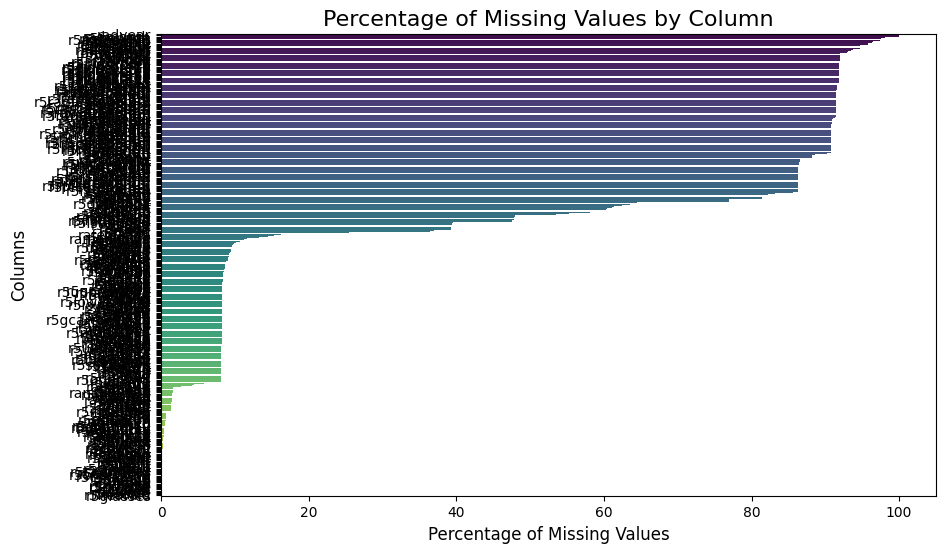


Removing columns with more than 30% missing values...


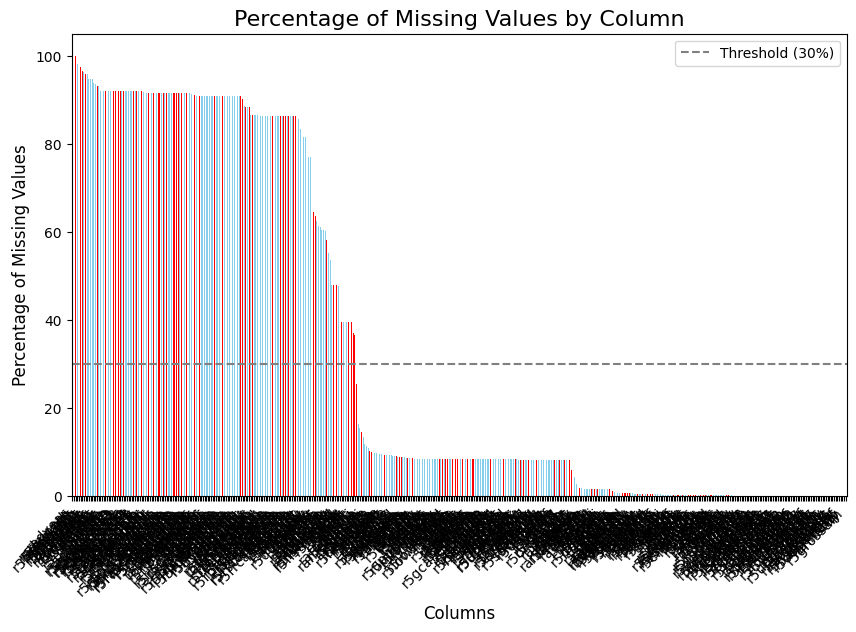

Dropping 172 columns (>30% missing): ['r5toilethlp', 'r5walkre', 'r5flstmnspd', 'r5rircare', 'r5rifcaren', 'r5stroklmt', 'r5retage', 'r5rifcaredpmm', 'r5rrcarehrm', 'r5rafcaredpm', 'r5rpfcaredpmm', 'r5breast', 'r5ripfcaredpmm', 'r5ciqscore9', 'r5resplmt', 'r5ripfcaredpm', 'r5reccancr', 'r5wander', 'r5rfaany', 'r5rifcare', 'r5racany', 'r5unemp', 'r5jcten', 'r5alone', 'r5moneyhlp', 'r5raccaredpmm', 'r5lifein_m', 'r5rifcarehr', 'r5rascare', 'r5strtsmok', 'r5rpfcare', 'r5riscare', 'r5ciqscore3', 'r5rscare', 'r5rscaredpm', 'r5ripfcaren', 'r5rfcare', 'r5rscaredpmm', 'r5riscaredpmm', 'r5rpfcarehrm', 'r5bed', 'r5rapfcaredpm', 'r5rarcare', 'r5prost', 'r5jhours', 'r5ripfcare', 'r5rifcaredpm', 'r5ripfcarehr', 'r5prchmem', 'r5ciqscore1', 'r5ciqscore8', 'r5rascaredpm', 'radmonth', 'r5racaany', 'r5rarcaredpmm', 'r5rarcarehr', 'r5eat', 'r5ciqscore7', 'r5jredhr', 'r5mammog', 'r5penage', 'r5bedhlp', 'r5rccaren', 'r5ciqscore16', 'r5rfcarehrm', 'r5riscarehrm', 'r5rascarehrm', 'r5rfcaredpm', 'r5raccarehr'

In [104]:
# Load the dataset
file_path = 'H_MHAS_c2.dta'
print("Loading the dataset...")
raw_df = pd.read_stata(file_path)
print(f"Dataset loaded successfully with shape: {raw_df.shape}")
print("Preview of the dataset:")
display(raw_df.head())  # Use display() for better rendering in Jupyter Notebook

# Step 1: Filter data from Wave 5
print("\nFiltering data for Wave 5...")
wave_5_df = extract_wave_data(raw_df, "5")
print(f"Wave 5 dataframe shape: {wave_5_df.shape}")

# Step 2: Include only direct respondents
print("\nFiltering data for direct respondents only...")
wave_5_respondents_df = extract_respondent_data(wave_5_df)
print(f"Wave 5 respondent-only dataframe shape: {wave_5_respondents_df.shape}")

# Step 3: Filter for elderly individuals aged 50 or older
print("\nFiltering data for elderly individuals (aged 50+)...")
elderly_individuals_df = filter_by_age(wave_5_respondents_df)
print(f"Wave 5 elderly individuals dataframe shape: {elderly_individuals_df.shape}")

# Step 4: Exclude individuals who passed away
print("\nExcluding individuals who passed away during the waves...")
alive_individual_df = filter_alive_respondents(elderly_individuals_df)
print(f"Wave 5 alive individuals dataframe shape: {alive_individual_df.shape}")

# Step 5: Visualize missing values
print("\nVisualizing missing values...")
plot_missing_values(alive_individual_df)

# Step 6: Remove columns with more than 30% missing values
missing_percentage_threshold = 30
print(f"\nRemoving columns with more than {missing_percentage_threshold}% missing values...")
df_filtered_by_missing_values = remove_columns_with_missing_values(alive_individual_df, missing_percentage_threshold)
print(f"Dataframe shape after removing columns with excessive missing values: {df_filtered_by_missing_values.shape}")

# Step 7: Handle the target column (r5hosp1y)
target_column = 'r5hosp1y'
target_mapping = {'1.Yes': 1, '0.No': 0}
print(f"\nProcessing the target column '{target_column}'...")
cleaned_df = (
    df_filtered_by_missing_values
    .dropna(subset=[target_column])  # Remove rows with missing target values
    .assign(**{target_column: df_filtered_by_missing_values[target_column].map(target_mapping)})  # Map to 1s and 0s
)
print(f"Dataframe shape after processing target column: {cleaned_df.shape}")

# Step 8: Handle missing values for all columns (excluding the target column)
print("\nHandling missing values for all columns...")
final_data = handle_all_missing_as_category(cleaned_df, target_column=target_column)
print(f"Final dataset shape: {final_data.shape}")

# Step 9: Save the cleaned dataset
output_path = 'cleaned_dataset.csv'
final_data.to_csv(output_path, index=False)
print(f"\nCleaned dataset saved successfully to {output_path}")


<ipython-input-103-50447ff25624>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="coolwarm")


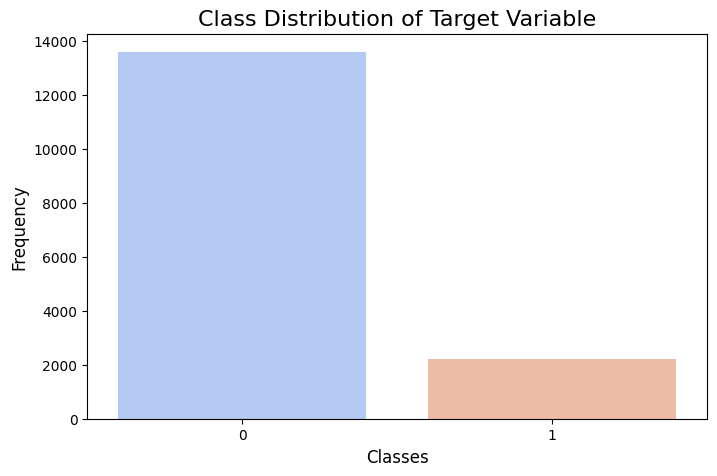

Class Distribution:
r5hosp1y
0    13595
1     2212
Name: count, dtype: int64
Class Ratios:
r5hosp1y
0    86.0062
1    13.9938
Name: count, dtype: float64


In [105]:
data = final_data.copy()

plot_class_distribution(data ['r5hosp1y'])

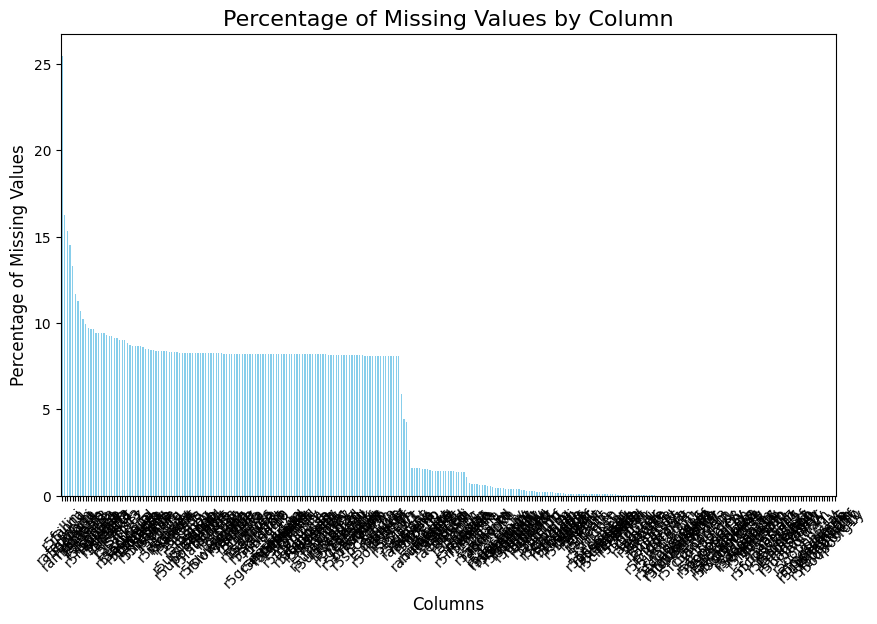

Columns dropped (>30% missing): []


,r5ipeno,r5dy,raliterate,r5doctor1y,r5iwstat,r5adlfivem,r5wakeup,r5fciqscore8,r5lexcl3,r5doctim1y,...,r5cncrradn,r5iwy,r5adltot6a,r5energ,r5lideal3,r5dentim1y,r5fciqscore13,r5drink,r5cesd_m,r5cancre
1,0.0,1.Correct,1.Yes,0.No,"1.Resp, alive",0.0,2.Sometimes,"-1.Missing, not imputed",3.Agree,0.0,...,0.no,2018.0,0.No,1.Yes,3.Agree,0.0,"-1.Missing, not imputed",0.no,3.0,0.no
2,0.0,1.Correct,1.Yes,1.Yes,"1.Resp, alive",0.0,3.Rarely or never,"-1.Missing, not imputed",3.Agree,6.0,...,0.no,2018.0,0.No,1.Yes,3.Agree,0.0,"-1.Missing, not imputed",0.no,1.0,0.no
4,0.0,1.Correct,1.Yes,1.Yes,"1.Resp, alive",0.0,2.Sometimes,"-1.Missing, not imputed",3.Agree,1.0,...,0.no,2018.0,0.No,0.No,2.Neutral,2.0,"-1.Missing, not imputed",0.no,3.0,0.no
7,0.0,1.Correct,0.No,1.Yes,"1.Resp, alive",0.0,3.Rarely or never,"-1.Missing, not imputed",3.Agree,12.0,...,0.no,2018.0,1.Yes,1.Yes,2.Neutral,4.0,"-1.Missing, not imputed",0.no,1.0,0.no
8,0.0,0.Incorrect,0.No,0.No,"1.Resp, alive",0.0,1.Most of the time,"-1.Missing, not imputed",3.Agree,0.0,...,0.no,2018.0,1.Yes,1.Yes,2.Neutral,0.0,"-1.Missing, not imputed",0.no,5.0,0.no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26834,0.0,1.Correct,1.Yes,1.Yes,"1.Resp, alive",0.0,3.Rarely or never,"-1.Missing, not imputed",3.Agree,2.0,...,0.no,2018.0,0.No,0.No,3.Agree,0.0,"-1.Missing, not imputed",0.no,6.0,0.no
26835,0.0,1.Correct,1.Yes,1.Yes,"1.Resp, alive",0.0,2.Sometimes,"-1.Missing, not imputed",2.Neutral,2.0,...,0.no,2018.0,0.No,1.Yes,3.Agree,1.0,"-1.Missing, not imputed",1.yes,2.0,0.no
26836,0.0,0.Incorrect,1.Yes,1.Yes,"1.Resp, alive",0.0,2.Sometimes,"-1.Missing, not imputed",3.Agree,3.0,...,0.no,2018.0,1.Yes,1.Yes,3.Agree,0.0,"-1.Missing, not imputed",0.no,6.0,0.no
26837,0.0,1.Correct,1.Yes,0.No,"1.Resp, alive",0.0,3.Rarely or never,"-1.Missing, not imputed",2.Neutral,0.0,...,0.no,2018.0,0.No,1.Yes,1.Disagree,0.0,"-1.Missing, not imputed",0.no,5.0,0.no


In [106]:
# Remove variables with more than 30% of messing values

analyze_and_handle_missing_values(df_filtered_by_missing_values, threshold=30)

In [107]:
data = final_data.copy()

# Step 1: Select categorical columns
print("Selecting categorical columns from the dataset...")
categorical_data = data.select_dtypes(include=['object', 'category'])
print(f"Number of categorical columns identified: {len(categorical_data.columns)}")
print("Categorical columns:")
for col in categorical_data.columns:
    print(f"- {col}")

# Step 2: Select numerical columns
print("\nSelecting numerical columns from the dataset...")
numerical_data = data.select_dtypes(include=['int64', 'float64'])
print(f"Number of numerical columns identified: {len(numerical_data.columns)}")
print("Numerical columns:")
for col in numerical_data.columns:
    print(f"- {col}")


Selecting categorical columns from the dataset...
Number of categorical columns identified: 212
Categorical columns:
- r5dy
- raliterate
- r5doctor1y
- r5iwstat
- r5wakeup
- r5fciqscore8
- r5lexcl3
- r5oopdocf1y
- r5clims
- r5walk1
- r5satlife_m
- r5higov
- r5nopencil
- r5lchnot3
- r5mealsa
- r5pusha
- r5fciqscore14
- r5inlbrf
- r5stoop
- r5fidraw1
- r5fciqscore6
- r5fciqscore9
- r5lstsf3
- r5rfcnt
- r5fddraw1
- r5cncrchem
- r5cncrothr
- r5armsa
- r5lbrf_m
- r5adlaa
- r5ifpubo
- r5oophosf1y
- r5fyr
- r5hearte
- r5covr_m
- r5money
- r5rxdiabi
- r5nagi8a
- r5gcaresckd_m
- r5stoopa
- r5arms
- r5dress
- r5ifpubpen
- rafeduc_m
- r5pstmem
- r5diabe
- r5sleepr
- ragender
- r5nagi10a
- r5ifothr
- rahhidnp
- r5grossaa
- r5flusht
- r5rfcntx_m
- r5fciqscore4
- r5fser7
- r5moneya
- r5peninc
- r5genderf
- raeducl
- r5eata
- r5urincgh2y
- r5hltc
- r5relgwk
- r5ftrhlp
- r5lift
- r5clim1a
- r5rxarthr
- r5dimea
- r5yr
- r5ifpent
- r5rxdiabo
- r5mstat
- r5drinkb
- r5lifta
- r5enlife
- r5ftired
- r5upper

### Cramér's V Matrix

A **Cramér's V matrix** is a correlation matrix that measures the association between categorical variables in a dataset. It is derived from the **Cramér's V statistic**, which is based on the Chi-squared test of independence.

**Cramér's V** was used to quantify the strength of association between two categorical variables, producing a value between **0** and **1**:
- **0** indicates no association (independence).
- **1** indicates a perfect association.

The matrix provides pairwise Cramér's V values for all combinations of categorical variables in the dataset.



In [108]:
# Step 2: Calculate the Cramér's V matrix

print("\nCalculating Cramér's V correlation matrix for categorical columns...")
cramers_matrix = cramers_v_matrix(data)
print("Cramér's V Correlation Matrix calculation complete.")

# Step 3: Display the Cramér's V matrix
print("\nCramér's V Correlation Matrix:")
print(cramers_matrix)




Calculating Cramér's V correlation matrix for categorical columns...
Cramér's V Correlation Matrix calculation complete.

Cramér's V Correlation Matrix:
                   r5dy  raliterate  r5doctor1y  r5iwstat  r5wakeup  \
r5dy           1.000000    0.179747    0.028668       NaN  0.704493   
raliterate     0.179747    1.000000    0.012573       NaN  0.082576   
r5doctor1y     0.028668    0.012573    1.000000       NaN  0.067530   
r5iwstat            NaN         NaN         NaN       1.0       NaN   
r5wakeup       0.704493    0.082576    0.067530       NaN  1.000000   
...                 ...         ...         ...       ...       ...   
r5energ        0.694677    0.085157    0.043139       NaN  0.696077   
r5lideal3      0.639844    0.102862    0.041685       NaN  0.523209   
r5fciqscore13  0.707107    0.076910    0.018569       NaN  0.704387   
r5drink        0.047958    0.060261    0.155433       NaN  0.046768   
r5cancre       0.026871    0.011714    0.057439       NaN  0.0388

In [109]:
# Step 4: Visualize the Cramér's V matrix using a heatmap
# print("\nVisualizing the Cramér's V Correlation Matrix...")
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 8))
# sns.heatmap(cramers_matrix, annot=True, cmap="coolwarm", fmt=".2f")
# plt.title("Cramér's V Correlation Matrix", fontsize=16)
# plt.xlabel("Columns", fontsize=12)
# plt.ylabel("Columns", fontsize=12)
# plt.xticks(rotation=45, fontsize=10)
# plt.yticks(fontsize=10)
# plt.tight_layout()
# plt.show()
# print("Cramér's V Correlation Matrix visualization complete.")

In [110]:
# Step 5: Remove redundant features
print("\nStep 5: Removing redundant features based on Cramér's V matrix...")
print(f"Threshold for removing redundant features: {0.8}")
print(f"Target column to preserve: 'r5hosp1y'")

# Remove redundant features using the precomputed Cramér's V matrix
final_df = remove_redundant_features_cramers(
    df=data,
    cramers_matrix=cramers_matrix,
    threshold=0.8,
    target_column='r5hosp1y'
)

# Step 6: Display results after removing redundant features
print("\nRedundant features removal complete.")
print(f"Final dataframe shape: {final_df.shape}")

# Step 7: List the remaining features
print("\nRemaining features in the final dataframe:")
remaining_features = list(final_df.columns)
print(f"Number of features retained: {len(remaining_features)}")
print("Features retained:")
for feature in remaining_features:
    print(f"- {feature}")

# Optional: Save the resulting dataframe to a CSV for further use
output_path = 'final_cleaned_dataset_crammer.csv'
final_df.to_csv(output_path, index=False)
print(f"\nFinal cleaned dataset saved to: {output_path}")



Step 5: Removing redundant features based on Cramér's V matrix...
Threshold for removing redundant features: 0.8
Target column to preserve: 'r5hosp1y'
Removed 209 redundant features: {'r5walkra', 'r5eata', 'r5rxresp', 'r5dy', 'r5rxdiab', 'r5urincgh2y', 'r5slfmem', 'r5hltc', 'r5swell', 'r5relgwk', 'raliterate', 'r5socact_m', 'r5ftrhlp', 'r5lift', 'r5urinurg2y', 'r5breath_m', 'r5doctor1y', 'r5fciqscore5', 'r5clim1a', 'rameduc_m', 'r5wakeup', 'r5medsa', 'r5rxarthr', 'r5fciqscore8', 'r5lexcl3', 'r5dimea', 'r5yr', 'r5shopa', 'r5effort', 'r5oopdocf1y', 'r5clims', 'r5ifsret', 'r5ifpent', 'r5meds', 'r5jog', 'r5walk1', 'r5fallslp', 'r5climsa', 'r5rxstrok', 'r5retemp', 'r5ifpeno', 'r5shlt', 'r5fciqscore10', 'r5smoken', 'r5rxdiabo', 'r5batha', 'r5painlv', 'r5hearaid', 'r5mstat', 'r5rxhrtat', 'r5drinkb', 'raindlang', 'r5satlife_m', 'r5higov', 'r5nopencil', 'r5lifta', 'r5enlife', 'r5ftired', 'r5ifssdi', 'r5lchnot3', 'r5uppermoba', 'r5hipriv', 'r5adlwaa', 'r5chaira', 'r5mealsa', 'r5pusha', 'r5fciqs

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Step 1: Encode categorical features
print("\nStep 1: Encoding categorical features using LabelEncoder...")
df = final_df.copy()  # Create a copy of the final dataframe to avoid modifying the original
target_column = 'r5hosp1y'

# Loop through all categorical columns and encode them
for col in df.select_dtypes(include=['object', 'category']).columns:
    print(f"Encoding column: {col}")
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
print("Categorical encoding complete.\n")

# Step 2: Separate features and target variable
print("Step 2: Separating features and target variable...")
X = df.drop(columns=[target_column])  # Features
y = df[target_column]  # Target variable
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target variable: {target_column}\n")

# Step 3: Split the data into training and testing sets
print("Step 3: Splitting the dataset into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Training set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing set shape: X_test: {X_test.shape}, y_test: {y_test.shape}")
print("Dataset splitting complete.\n")

# Step 4: Balance the training data using SMOTE
print("Step 4: Balancing the training data using SMOTE...")
X_train_balanced, y_train_balanced = balance_data(X_train, y_train)
print("SMOTE balancing complete.\n")

# Step 5: Print the shape and distribution of the balanced dataset
print("Step 5: Balanced training data details:")
print(f"Balanced X_train shape: {X_train_balanced.shape}")
print("Balanced y_train distribution:")
print(y_train_balanced.value_counts())



Step 1: Encoding categorical features using LabelEncoder...
Encoding column: r5iwstat
Encoding column: r5iwf
Encoding column: r5hosp1y
Categorical encoding complete.

Step 2: Separating features and target variable...
Features shape: (15807, 87)
Target shape: (15807,)
Target variable: r5hosp1y

Step 3: Splitting the dataset into training and testing sets...
Training set shape: X_train: (11064, 87), y_train: (11064,)
Testing set shape: X_test: (4743, 87), y_test: (4743,)
Dataset splitting complete.

Step 4: Balancing the training data using SMOTE...
SMOTE balancing complete.

Step 5: Balanced training data details:
Balanced X_train shape: (19032, 87)
Balanced y_train distribution:
r5hosp1y
0    9516
1    9516
Name: count, dtype: int64


## LogisticRegression


Step 1: Training Logistic Regression model...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Step 2: Making predictions...

Step 3: Evaluating performance...
Model Accuracy: 0.9007
ROC AUC Score: 0.7307

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      4079
           1       0.93      0.31      0.47       664

    accuracy                           0.90      4743
   macro avg       0.91      0.66      0.71      4743
weighted avg       0.90      0.90      0.88      4743


Equal Opportunity Accuracy (EO_AC): 0.6554


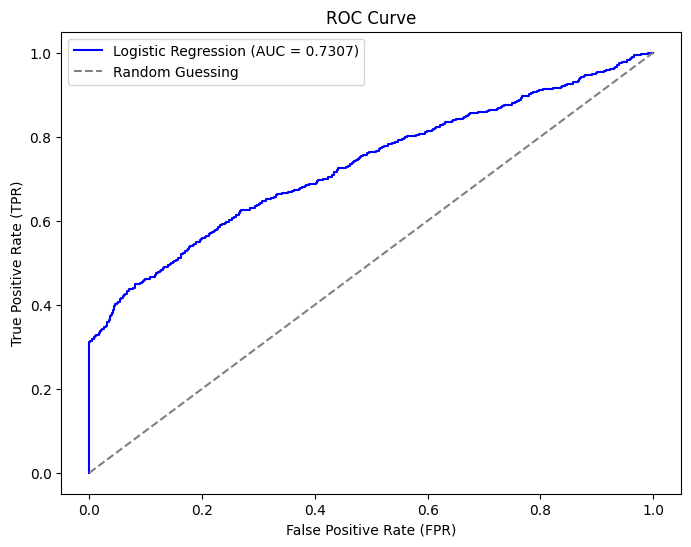

In [123]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Step 1: Train Logistic Regression
print("\nStep 1: Training Logistic Regression model...")
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_balanced, y_train_balanced)

# Step 2: Make predictions on the test set
print("Step 2: Making predictions...")
y_test_pred = logreg.predict(X_test)
y_test_probs = logreg.predict_proba(X_test)[:, 1]  # Probabilities for ROC/AUC

# Step 3: Evaluate Accuracy and Classification Report
print("\nStep 3: Evaluating performance...")
accuracy = accuracy_score(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_probs)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(report)

# Step 4: Calculate Equal Opportunity Accuracy (EO_AC)
# True positive rate and false negative rate for each class
positive_class = y_test[y_test == 1]
negative_class = y_test[y_test == 0]
positive_accuracy = accuracy_score(positive_class, y_test_pred[y_test == 1])
negative_accuracy = accuracy_score(negative_class, y_test_pred[y_test == 0])

eo_ac = (positive_accuracy + negative_accuracy) / 2
print(f"\nEqual Opportunity Accuracy (EO_AC): {eo_ac:.4f}")

# Step 5: Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.4f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()


# RandomForestClassifier

In [113]:
## Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Initialize the Random Forest Classifier
print("\nStep 1: Initializing the Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
print("Random Forest model initialized with n_estimators=100 and random_state=42.\n")

# Step 2: Train the model on the balanced training dataset
print("Step 2: Training the Random Forest Classifier on the balanced training data...")
rf_model.fit(X_train_balanced, y_train_balanced)
print("Model training complete.\n")

# Step 3: Make predictions on the test dataset
print("Step 3: Making predictions on the test dataset...")
y_test_pred_rf = rf_model.predict(X_test)
print("Predictions complete.\n")

# Step 4: Evaluate the model performance
print("Step 4: Evaluating the model performance...")
accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
report_rf = classification_report(y_test, y_test_pred_rf)

# Step 5: Display the evaluation results
print("Step 5: Displaying evaluation results...")
print(f"Random Forest Model Accuracy: {accuracy_rf:.4f}\n")
print("Classification Report:")
print(report_rf)



Step 1: Initializing the Random Forest Classifier...
Random Forest model initialized with n_estimators=100 and random_state=42.

Step 2: Training the Random Forest Classifier on the balanced training data...
Model training complete.

Step 3: Making predictions on the test dataset...
Predictions complete.

Step 4: Evaluating the model performance...
Step 5: Displaying evaluation results...
Random Forest Model Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4079
           1       1.00      1.00      1.00       664

    accuracy                           1.00      4743
   macro avg       1.00      1.00      1.00      4743
weighted avg       1.00      1.00      1.00      4743



In [114]:
import pandas as pd
import numpy as np

# Step 1: Get feature importances
print("\nStep 1: Extracting feature importances from the trained Random Forest model...")
feature_importances = rf_model.feature_importances_

# Step 2: Map feature importances to column names
print("Step 2: Mapping feature importances to feature names...")
importance_df = pd.DataFrame({
    'Feature': X_train_balanced.columns,
    'Importance': feature_importances
})

# Step 3: Sort features by importance
print("Step 3: Sorting features by importance...")
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display top 10 features
print("\nTop 10 most important features:")
print(importance_df.head(10))

# Optional: Filter the top N features based on a threshold or rank
n_top_features = 30
top_features = importance_df.head(n_top_features)['Feature'].tolist()

print(f"\nTop {n_top_features} features (based on importance):")
for feature in top_features:
    print(f"{feature}")

# Step 4: Optionally create a new dataset with only the top N features
print("\nStep 4: Creating a new dataset with only the top features...")
X_train_top = X_train_balanced[top_features]
X_test_top = X_test[top_features]

print(f"Shape of new training dataset: {X_train_top.shape}")
print(f"Shape of new test dataset: {X_test_top.shape}")



Step 1: Extracting feature importances from the trained Random Forest model...
Step 2: Mapping feature importances to feature names...
Step 3: Sorting features by importance...

Top 10 most important features:
       Feature  Importance
21  r5hspnit1y    0.473217
51  r5oophos1y    0.078379
3   r5doctim1y    0.036691
66    r5adla_m    0.032063
73    r5grossa    0.023092
30  r5uppermob    0.021722
53   r5fallnum    0.018211
37    r5mobila    0.017751
8   r5lowermob    0.017372
44    r5nagi10    0.017065

Top 30 features (based on importance):
r5hspnit1y
r5oophos1y
r5doctim1y
r5adla_m
r5grossa
r5uppermob
r5fallnum
r5mobila
r5lowermob
r5nagi10
r5mobilsev
r5adla
r5adltot6
r5lgmusa
r5oopmd1y
r5iadlfour
r5nagi8
r5adlfive
r5lsatsc3
r5iwm
r5adlwa
r5finea
r5dentim1y
r5fineam
r5uppermobm
r5height
r5ser7
r5bmi
r5nagi8m
raedyrs

Step 4: Creating a new dataset with only the top features...
Shape of new training dataset: (19032, 30)
Shape of new test dataset: (4743, 30)


In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Define and Train the Logistic Regression Model
print("\nStep 1: Training Logistic Regression with Top 30 Features...")
log_reg = LogisticRegression(max_iter=500, random_state=42)
log_reg.fit(X_train_top, y_train_balanced)

# Step 2: Make Predictions
print("\nStep 2: Making Predictions...")
y_pred_train = log_reg.predict(X_train_top)
y_pred_test = log_reg.predict(X_test_top)

# Step 3: Evaluate Model Performance
print("\nStep 3: Evaluating Model Performance...")

# Training accuracy
train_accuracy = accuracy_score(y_train_balanced, y_pred_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Test accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification Report
print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_pred_test))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))



Step 1: Training Logistic Regression with Top 30 Features...

Step 2: Making Predictions...

Step 3: Evaluating Model Performance...
Training Accuracy: 1.0000
Test Accuracy: 1.0000

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4079
           1       1.00      1.00      1.00       664

    accuracy                           1.00      4743
   macro avg       1.00      1.00      1.00      4743
weighted avg       1.00      1.00      1.00      4743


Confusion Matrix:
[[4079    0]
 [   0  664]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



ROC AUC Score: 1.0000


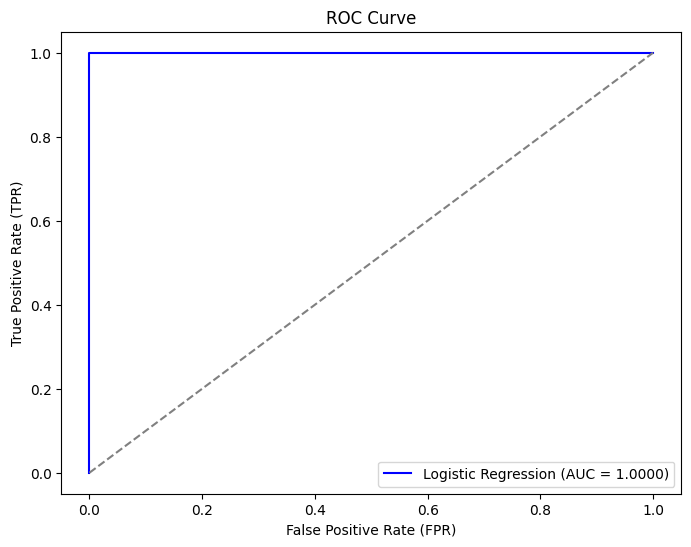

In [122]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_probs_test = log_reg.predict_proba(X_test_top)[:, 1]  # Get probability for class 1

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_probs_test)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Compute ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_probs_test)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Logistic Regression (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal baseline
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()



In [115]:
features_dict = {
    "r5hspnit1y": {"variable_explanation": "Hospital nights, previous 12 months", "variable_type": "Cont"},
    "r5oophos1y": {"variable_explanation": "Out of pocket hospital exp", "variable_type": "Cont"},
    "r5doctim1y": {"variable_explanation": "# Doctor visits, previous 12 months", "variable_type": "Cont"},
    "r5adla_m": {"variable_explanation": "Some difficulty-ADLs 0-4", "variable_type": "Cont"},
    "r5grossa": {"variable_explanation": "Some difficulty-Gross Motor 0-5", "variable_type": "Cont"},
    "r5uppermob": {"variable_explanation": "Some difficulty-Upper Body Mobility 0-3", "variable_type": "Cont"},
    "r5fallnum": {"variable_explanation": "Number of falls", "variable_type": "Cont"},
    "r5mobila": {"variable_explanation": "Some difficulty-Mobility 0-5", "variable_type": "Cont"},
    "r5lowermob": {"variable_explanation": "Some difficulty-Missings in Lower Body Mob", "variable_type": "Cont"},
    "r5nagi10": {"variable_explanation": "Some difficulty-NAGI Score 0-10", "variable_type": "Cont"},
    "r5mobilsev": {"variable_explanation": "Some difficulty-7 item Mobility 0-7", "variable_type": "Cont"},
    "r5adla": {"variable_explanation": "Some difficulty-ADLs 0-5", "variable_type": "Cont"},
    "r5adltot6": {"variable_explanation": "Some difficulty-Total ADLs 0-6", "variable_type": "Cont"},
    "r5lgmusa": {"variable_explanation": "Some difficulty-Large Muscle 0-4", "variable_type": "Cont"},
    "r5oopmd1y": {"variable_explanation": "Out of pocket med exp, previous 12 months", "variable_type": "Cont"},
    "r5iadlfour": {"variable_explanation": "Some difficulty-IADLs 0-4", "variable_type": "Cont"},
    "r5nagi8": {"variable_explanation": "Some difficulty-NAGI Score 0-8", "variable_type": "Cont"},
    "r5adlfive": {"variable_explanation": "Some difficulty-ADLs 0-5 Alternate", "variable_type": "Cont"},
    "r5lsatsc3": {"variable_explanation": "Satisfaction with life scale score", "variable_type": "Cont"},
    "r5iwm": {"variable_explanation": "Interview Month", "variable_type": "Cont"},
    "r5adlwa": {"variable_explanation": "Some difficulty-ADLs: Wallace 0-3", "variable_type": "Cont"},
    "r5finea": {"variable_explanation": "Some difficulty-Fine Motor 0-3", "variable_type": "Cont"},
    "r5dentim1y": {"variable_explanation": "Dental visits, previous 12 months", "variable_type": "Cont"},
    "r5fineam": {"variable_explanation": "Some difficulty-Missings in Fine Motor Score", "variable_type": "Cont"},
    "r5uppermobm": {"variable_explanation": "Some difficulty-Missings in Upper Body Mob", "variable_type": "Cont"},
    "r5height": {"variable_explanation": "Height in meters", "variable_type": "Cont"},
    "r5ser7": {"variable_explanation": "Serial 7's number of correct subtractions", "variable_type": "Cont"},
    "r5bmi": {"variable_explanation": "Body Mass Index=kg/m2", "variable_type": "Cont"},
    "r5nagi8m": {"variable_explanation": "Some difficulty-Missings in 8-item NAGI Score", "variable_type": "Cont"},
    "raedyrs": {"variable_explanation": "Years of Education", "variable_type": "Cont"}
}

# Print the dictionary to verify
print(features_dict)


{'r5hspnit1y': {'variable_explanation': 'Hospital nights, previous 12 months', 'variable_type': 'Cont'}, 'r5oophos1y': {'variable_explanation': 'Out of pocket hospital exp', 'variable_type': 'Cont'}, 'r5doctim1y': {'variable_explanation': '# Doctor visits, previous 12 months', 'variable_type': 'Cont'}, 'r5adla_m': {'variable_explanation': 'Some difficulty-ADLs 0-4', 'variable_type': 'Cont'}, 'r5grossa': {'variable_explanation': 'Some difficulty-Gross Motor 0-5', 'variable_type': 'Cont'}, 'r5uppermob': {'variable_explanation': 'Some difficulty-Upper Body Mobility 0-3', 'variable_type': 'Cont'}, 'r5fallnum': {'variable_explanation': 'Number of falls', 'variable_type': 'Cont'}, 'r5mobila': {'variable_explanation': 'Some difficulty-Mobility 0-5', 'variable_type': 'Cont'}, 'r5lowermob': {'variable_explanation': 'Some difficulty-Missings in Lower Body Mob', 'variable_type': 'Cont'}, 'r5nagi10': {'variable_explanation': 'Some difficulty-NAGI Score 0-10', 'variable_type': 'Cont'}, 'r5mobilsev'

In [117]:
for i, (key, value) in enumerate(features_dict.items(), start=1):
    print(f"{i}. Variable: {key}")
    print(f"   Explanation: {value['variable_explanation']}")
    print(f"   Type: {value['variable_type']}")
    print("-" * 50)


1. Variable: r5hspnit1y
   Explanation: Hospital nights, previous 12 months
   Type: Cont
--------------------------------------------------
2. Variable: r5oophos1y
   Explanation: Out of pocket hospital exp
   Type: Cont
--------------------------------------------------
3. Variable: r5doctim1y
   Explanation: # Doctor visits, previous 12 months
   Type: Cont
--------------------------------------------------
4. Variable: r5adla_m
   Explanation: Some difficulty-ADLs 0-4
   Type: Cont
--------------------------------------------------
5. Variable: r5grossa
   Explanation: Some difficulty-Gross Motor 0-5
   Type: Cont
--------------------------------------------------
6. Variable: r5uppermob
   Explanation: Some difficulty-Upper Body Mobility 0-3
   Type: Cont
--------------------------------------------------
7. Variable: r5fallnum
   Explanation: Number of falls
   Type: Cont
--------------------------------------------------
8. Variable: r5mobila
   Explanation: Some difficulty-Mobi

In [118]:
features_explanations = {
    "r5hspnit1y": "Previous hospitalizations indicate chronic conditions or frequent healthcare needs.",
    "r5oophos1y": "Higher out-of-pocket hospital expenses may indicate severe past illnesses.",
    "r5doctim1y": "Frequent doctor visits suggest ongoing medical issues requiring care.",
    "r5adla_m": "ADL difficulty shows reduced independence, linked to frailty and hospitalization.",
    "r5grossa": "Gross motor difficulty may indicate neuromuscular disorders or fall risk.",
    "r5uppermob": "Upper mobility issues can signal neuromuscular decline or severe arthritis.",
    "r5fallnum": "A higher number of falls is associated with injuries and hospitalization risk.",
    "r5mobila": "General mobility difficulties predict dependency and potential health decline.",
    "r5lowermob": "Lower body mobility issues increase fall and injury risks.",
    "r5nagi10": "NAGI score assesses physical function; lower scores suggest increased frailty.",
    "r5mobilsev": "Severe mobility impairment is linked to chronic disease and hospitalization.",
    "r5adla": "ADL difficulties indicate dependency, which increases hospitalization likelihood.",
    "r5adltot6": "Total ADL limitations reflect overall physical decline and care needs.",
    "r5lgmusa": "Large muscle difficulty can signal progressive conditions like Parkinson’s.",
    "r5oopmd1y": "High medication costs indicate chronic disease and higher healthcare needs.",
    "r5iadlfour": "IADL difficulties suggest cognitive or physical decline, leading to hospitalization.",
    "r5nagi8": "Lower NAGI scores predict limited physical ability and health risks.",
    "r5adlfive": "Another ADL measure showing functional limitations linked to hospitalization.",
    "r5lsatsc3": "Low life satisfaction may correlate with chronic illness or mental health decline.",
    "r5iwm": "Interview month may help adjust for seasonal hospitalization trends.",
    "r5adlwa": "Wallace ADL score measures functional decline, a key hospitalization predictor.",
    "r5finea": "Fine motor difficulty may indicate neurological conditions affecting independence.",
    "r5dentim1y": "Dental visits show health awareness; poor oral health may signal systemic issues.",
    "r5fineam": "Fine motor impairments can impact self-care and indicate neurological decline.",
    "r5uppermobm": "Upper mobility issues may indicate stroke or musculoskeletal problems.",
    "r5height": "Height may relate to frailty; shorter individuals may have higher hospitalization risk.",
    "r5ser7": "Serial 7’s test assesses cognition; poor results may indicate cognitive decline.",
    "r5bmi": "BMI outside the normal range is linked to obesity, malnutrition, or chronic illness.",
    "r5nagi8m": "Missings in NAGI scores may indicate underlying health disparities.",
    "raedyrs": "Lower education levels are linked to poorer health literacy and outcomes."
}

for i, (key, explanation) in enumerate(features_explanations.items(), start=1):
    print(f"{i}. Variable: {key}")
    print(f"   Short Explanation: {explanation}")
    print("-" * 80)


1. Variable: r5hspnit1y
   Short Explanation: Previous hospitalizations indicate chronic conditions or frequent healthcare needs.
--------------------------------------------------------------------------------
2. Variable: r5oophos1y
   Short Explanation: Higher out-of-pocket hospital expenses may indicate severe past illnesses.
--------------------------------------------------------------------------------
3. Variable: r5doctim1y
   Short Explanation: Frequent doctor visits suggest ongoing medical issues requiring care.
--------------------------------------------------------------------------------
4. Variable: r5adla_m
   Short Explanation: ADL difficulty shows reduced independence, linked to frailty and hospitalization.
--------------------------------------------------------------------------------
5. Variable: r5grossa
   Short Explanation: Gross motor difficulty may indicate neuromuscular disorders or fall risk.
-----------------------------------------------------------------

### **1. Medical History**
These variables reflect the frequency of healthcare interactions and can indicate chronic conditions or the need for frequent medical attention.

| Variable       | Short Explanation |
|---------------|------------------|
| **r5hspnit1y** | Previous hospitalizations suggest chronic conditions or frequent medical needs. |
| **r5oophos1y** | High out-of-pocket hospital expenses may indicate severe illnesses or costly treatments. |
| **r5doctim1y** | Frequent doctor visits suggest ongoing medical issues requiring continuous care. |
| **r5oopmd1y** | High medication expenses indicate multiple chronic conditions. |
| **r5dentim1y** | Dental visits show health awareness, while lack of visits may indicate systemic issues. |

---

### **2. Mobility and Physical Function**
These variables reflect a person’s physical ability. Reduced mobility and functionality predict a higher risk of hospitalization due to falls, fractures, and dependency.

| Variable       | Short Explanation |
|---------------|------------------|
| **r5adla_m** | Difficulty with Activities of Daily Living (ADLs) indicates growing dependency. |
| **r5grossa** | Gross motor difficulties reflect muscle weakness and increased fall risk. |
| **r5uppermob** | Upper body mobility issues may affect essential daily tasks. |
| **r5fallnum** | Frequent falls are a strong predictor of hospitalization and fractures. |
| **r5mobila** | General mobility difficulties may indicate neurodegenerative diseases. |
| **r5lowermob** | Lower body mobility issues increase the risk of falls and injuries. |
| **r5mobilsev** | Severe mobility impairment is associated with chronic disease progression. |
| **r5lgmusa** | Large muscle difficulties may indicate conditions such as multiple sclerosis. |

---

### **3. Functional Dependency and Cognitive Difficulties**
These variables indicate physical and cognitive limitations, which increase the likelihood of hospitalization.

| Variable       | Short Explanation |
|---------------|------------------|
| **r5adla** | More ADL difficulties predict greater dependency and hospitalization risk. |
| **r5adltot6** | Total ADL score measures overall functionality and care needs. |
| **r5iadlfour** | Difficulty with Instrumental ADLs (IADLs) may indicate cognitive or physical decline. |
| **r5adlfive** | Alternate ADL measure showing independence in basic activities. |
| **r5adlwa** | Wallace ADL score, another indicator of functional decline and hospitalization risk. |
| **r5finea** | Fine motor difficulties may signal neurological conditions. |
| **r5fineam** | Loss of fine motor skills affects independence in daily activities. |

---

### **4. Cognitive and Psychological Factors**
These variables measure a person’s mental and emotional state. Cognitive and emotional issues can increase vulnerability to illness and hospitalization.

| Variable       | Short Explanation |
|---------------|------------------|
| **r5nagi10** | Physical function assessment; lower scores indicate increased frailty. |
| **r5nagi8** | A variation of the NAGI score, related to physical functionality. |
| **r5nagi8m** | Missing NAGI scores may indicate underlying health disparities. |
| **r5lsatsc3** | Low life satisfaction may be associated with chronic illness or depression. |
| **r5ser7** | Serial 7s cognitive test; poor performance may indicate cognitive decline. |

---

### **5. Demographic and Anthropometric Factors**
These variables provide information on physical and educational characteristics, which can influence health and hospitalization risk.

| Variable       | Short Explanation |
|---------------|------------------|
| **r5iwm** | Interview month may help adjust for seasonal hospitalization trends. |
| **r5uppermobm** | Upper mobility difficulties may indicate stroke or musculoskeletal disorders. |
| **r5height** | Height may relate to frailty; shorter individuals may have higher hospitalization risk. |
| **r5bmi** | BMI outside the normal range is linked to obesity, malnutrition, or chronic illness. |
| **raedyrs** | Fewer years of education correlate with lower health literacy and worse health outcomes. |

---

### **Conclusion**
These variables help predict hospitalizations due to:
1. **Medical history:** People with multiple doctor visits and previous hospitalizations have a higher risk.
2. **Mobility and functionality:** Reduced ability to move and perform daily tasks increases vulnerability.
3. **Dependency and cognitive decline:** Loss of independence and mental deterioration can lead to situations requiring hospitalization.
4. **Psychological factors:** Low life satisfaction and cognitive impairment can affect physical health.
5. **Physical and educational factors:** Physical characteristics and education levels influence general health and access to care.


### **ADL (Activities of Daily Living)**  
ADL refers to **basic self-care activities** that individuals need to perform daily to live independently. These activities are often used to assess functional status, particularly in older adults or people with disabilities.  

There are **two types** of ADLs:  

1. **Basic ADLs (BADLs)** – These are fundamental self-care tasks:
   - Bathing
   - Dressing
   - Eating
   - Using the toilet
   - Transferring (e.g., moving from bed to chair)
   - Walking or moving around  

2. **Instrumental ADLs (IADLs)** – These are more complex tasks that require cognitive and physical abilities:
   - Managing finances
   - Cooking and meal preparation
   - Shopping for groceries
   - Housekeeping
   - Using transportation
   - Managing medications  

A decline in ADLs suggests **functional impairment**, which increases the likelihood of hospitalization, nursing home admission, and long-term care needs.  

---

### **NAGI (Nagi Disability Scale)**  
The **Nagi Scale** is a measure of **functional limitations** and **disability** related to physical movement. It is named after **Saad Nagi**, a sociologist who studied disability.  

The scale assesses **difficulty in performing specific physical tasks**, such as:  
- Walking long distances  
- Climbing stairs  
- Lifting heavy objects  
- Reaching overhead  
- Gripping small objects  
- Stooping or kneeling  

The **NAGI score** is often used in research to predict disability progression, hospitalization risk, and overall physical decline. **Higher difficulty in NAGI tasks is associated with greater frailty and risk of needing medical intervention.**  

---

### **How ADL and NAGI Predict Hospitalization**  
- **ADL impairment** → Suggests loss of independence and increased vulnerability to accidents, infections, and complications.  
- **High NAGI scores** → Indicate limited physical function, which can lead to falls, immobility, and hospital admissions.  

Both measures are commonly used in **geriatrics, rehabilitation, and disability assessments** to determine care needs and predict health outcomes.